# Social Graph Analysis Group Project

### Grandma’s Cookbook, Lookbook: An Analysis of Ingredients Association With Ethnic Cuisines

#### Group Members:
* Nick Potts
* Kristi Conry
* Jacob Lebowitz
* Anthony Bryson

### Possible Goals :)

1) Predict popular cuisine's based on what ingediants you have <br>
2) Essential ingrediants if you like a favorite cuisine <br>
3) Ingrediant recommendation system ( if you lke 3 types of cuisine find top similar ingrediants ) 

### Just some questions for our data :)

1) Which cuisine's are most similar based on ingediants? and why?

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
import collections
import re
import pickle

from gensim.models import word2vec

# Modelling Helpers, see above the description
from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [10]:
df = pd.read_csv('data/cleaned_data.csv', converters={'ingredient_list_cleaned': lambda x: x[1:-1].replace("'", '').split(','),
                                                      'ingredients': lambda x: x[1:-1].replace("'", '').split(',')})

In [11]:
df.head()

,id,cuisine,ingredients,ingredients_sentence,ingredient_cleaned,ingredient_list_cleaned
0,10259,greek,"[romaine lettuce, black olives, grape tomato...",romaine lettuce black olives grape tomatoes ga...,romain lettuc black oliv grape tomato garlic p...,"[romain lettuc, black oliv, grape tomato, g..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes...",plain flour ground pepper salt tomatoes ground...,plain flour ground pepper salt tomato ground b...,"[plain flour, ground pepper, salt, tomato, ..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oi...",eggs pepper salt mayonaise cooking oil green c...,egg pepper salt mayonais cook oil green chili ...,"[egg, pepper, salt, mayonais, cook oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt,water veget oil wheat salt,"[water, veget oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne...",black pepper shallots cornflour cayenne pepper...,black pepper shallot cornflour cayenn pepper o...,"[black pepper, shallot, cornflour, cayenn p..."


In [15]:
df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [30]:
real_ingredients = []

for ingredients in df['ingredient_list_cleaned']:
    for ingredient in ingredients:
        real_ingredients.append(ingredient.strip())
        
count_of_ingredient = collections.Counter(real_ingredients)
count_of_ingredient.most_common(10)

[('salt', 18049),
 ('onion', 7972),
 ('oliv oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic clove', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('allpurpos flour', 4632)]

In [31]:
len(count_of_ingredient.keys())

6666

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='cuisine', ylabel='count'>

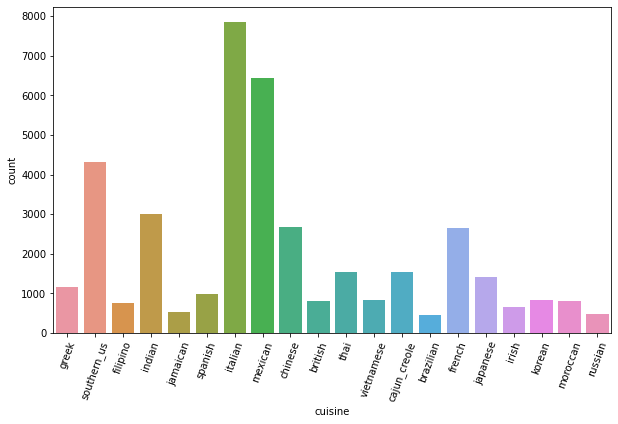

In [18]:
fig = plt.figure(figsize=[10,6])

plt.xticks(rotation=70)

sns.countplot(df['cuisine'])

In [19]:
count_of_ingredient_ordered = sorted(count_of_ingredient.items(), key=lambda x: x[1], reverse=True)

<AxesSubplot:>

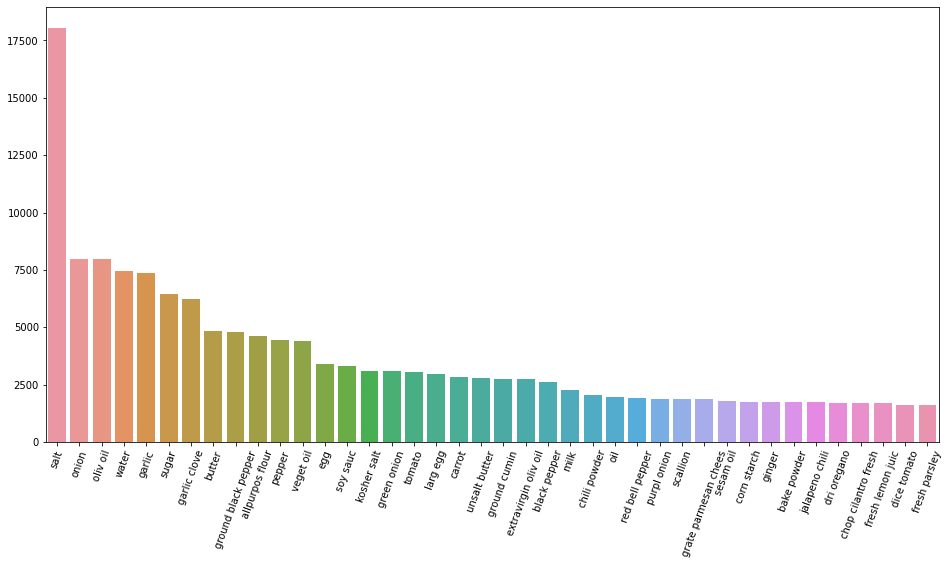

In [20]:
count_of_ingredient.most_common(10)

ingredients = []
counter = []

for counted_ingredients in count_of_ingredient.most_common(40):
    ingredients.append(counted_ingredients[0])
    counter.append(counted_ingredients[1])
    
fig = plt.figure(figsize=[16,8])

plt.xticks(rotation=70)

sns.barplot(x=ingredients, y=counter)

In [28]:
sentences = []

for ingredients in df['ingredient_list_cleaned']:
    cleaned_ing = []
    for ingredient in ingredients:
        ingredient = re.sub('r\(.*oz\)|minced|poweder|chopped|sliced|paste|crushed|ground|diced', '', ingredient)
        cleaned_ing.append(ingredient.strip())
    sentences.append(cleaned_ing)
    
print(len(sentences))
print(sentences[:10])

39774
[['romain lettuc', 'black oliv', 'grape tomato', 'garlic', 'pepper', 'purpl onion', 'season', 'garbanzo bean', 'feta chees crumbl'], ['plain flour', 'pepper', 'salt', 'tomato', 'black pepper', 'thyme', 'egg', 'green tomato', 'yellow corn meal', 'milk', 'veget oil'], ['egg', 'pepper', 'salt', 'mayonais', 'cook oil', 'green chili', 'grill chicken breast', 'garlic powder', 'yellow onion', 'soy sauc', 'butter', 'chicken liver'], ['water', 'veget oil', 'wheat', 'salt'], ['black pepper', 'shallot', 'cornflour', 'cayenn pepper', 'onion', 'garlic past', 'milk', 'butter', 'salt', 'lemon juic', 'water', 'chili powder', 'passata', 'oil', 'cumin', 'boneless chicken skinless thigh', 'garam masala', 'doubl cream', 'natur yogurt', 'bay leaf'], ['plain flour', 'sugar', 'butter', 'egg', 'fresh ginger root', 'salt', 'cinnamon', 'milk', 'vanilla extract', 'ginger', 'powder sugar', 'bake powder'], ['oliv oil', 'salt', 'medium shrimp', 'pepper', 'garlic', 'chop cilantro', 'jalapeno chili', 'flat leaf

In [85]:
keys = count_of_ingredient.keys()
values = count_of_ingredient.values()

import statistics

print('Number of Ingredients - unqiue count')

print(f'mean = {statistics.mean(values)}')

print(f'90th% percentile = {np.quantile(list(values), 0.90)}')
print(f'70th% percentile = {np.quantile(list(values), 0.70)}')
print(f'50th% percentile = {np.quantile(list(values), 0.50)}')
print(f'30th% percentile = {np.quantile(list(values), 0.30)}')
print(f'10th% percentile = {np.quantile(list(values), 0.10)}\n\n')

print('Length of Sentences')

len_of_sentences = df['ingredient_list_cleaned'].apply(lambda x: len(x))

print(f'mean = {statistics.mean(len_of_sentences)}')

print(f'90th% percentile = {np.quantile(list(len_of_sentences), 0.90)}')
print(f'70th% percentile = {np.quantile(list(len_of_sentences), 0.70)}')
print(f'50th% percentile = {np.quantile(list(len_of_sentences), 0.50)}')
print(f'30th% percentile = {np.quantile(list(len_of_sentences), 0.30)}')
print(f'10th% percentile = {np.quantile(list(len_of_sentences), 0.10)}')

Number of Ingredients - unqiue count
mean = 64.24767476747675
90th% percentile = 94.0
70th% percentile = 14.0
50th% percentile = 4.0
30th% percentile = 2.0
10th% percentile = 1.0


Length of Sentences
mean = 10.76771257605471
90th% percentile = 17.0
70th% percentile = 13.0
50th% percentile = 10.0
30th% percentile = 8.0
10th% percentile = 6.0


In [86]:
num_of_features = 250 # Dimensionality of the word vectors.

min_word_count = 4 # Ignores all words with total frequency lower than this.

num_workers = 4 # Use these many worker threads to train the model

window_context = 6 # Maximum distance between the current and predicted word within a sentence.

sample = 1e-3 # The threshold for configuring which higher-frequency words are randomly downsampled.

In [87]:
model = word2vec.Word2Vec(sentences, size=num_of_features,
                          min_count=min_word_count, workers=num_workers,
                          window=window_context, sample=sample)

In [94]:
model.wv.most_similar('jalapeno chili')

[('tomatillo', 0.9582901000976562),
 ('poblano chile', 0.9379202723503113),
 ('mexican oregano', 0.9372552037239075),
 ('adobo sauc', 0.934597373008728),
 ('avocado', 0.9309493899345398),
 ('chipotl adobo', 0.9251047372817993),
 ('queso fresco', 0.9249072074890137),
 ('corn tortilla', 0.9243230223655701),
 ('cotija', 0.9241731762886047),
 ('poblano pepper', 0.9112868309020996)]

In [95]:
model.wv.similarity('fresh pineappl', 'milk')

0.055928193